<a href="https://colab.research.google.com/github/varad0207/GAN-Anomaly-Detection/blob/main/GAN_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network for Anomlay detection

This notebook covers training of generator, discriminator and a GAN model. These models are trained on non-anomalous data and the goal is to use the trained discriminator to classify the data as anomalous and non-anomalous

In [ ]:
import io
from google.colab import files
uploaded = files.upload()

Saving Twitter_volume_AAPL.csv to Twitter_volume_AAPL.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_fscore_support, classification_report, ConfusionMatrixDisplay, confusion_matrix

This function acquires the dataset and divides it into anomalous and non-anomalous data for training purpose

In [ ]:
def split_anomalies():

  df = pd.read_csv(io.StringIO(uploaded['Twitter_volume_AAPL.csv'].decode('utf-8')))

  anomaly_points = [
    ["2015-03-03 04:37:53.000000", "2015-03-04 13:37:53.000000"],
    ["2015-03-09 01:02:53.000000", "2015-03-10 10:02:53.000000"],
    ["2015-03-15 10:27:53.000000", "2015-03-16 19:27:53.000000"],
    ["2015-03-30 10:57:53.000000", "2015-03-31 19:57:53.000000"]
  ]

  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['anomaly'] = 0
  for start, end in anomaly_points:
    df.loc[((df['timestamp'] >= start) & (df['timestamp'] <= end)), 'anomaly'] = 1

  df['year'] = df['timestamp'].apply(lambda x : x.year)
  df['month'] = df['timestamp'].apply(lambda x : x.month)
  df['day'] = df['timestamp'].apply(lambda x : x.day)
  df['hour'] = df['timestamp'].apply(lambda x : x.hour)
  df['minute'] = df['timestamp'].apply(lambda x : x.minute)

  df.index = df['timestamp']
  df.drop(['timestamp'], axis=1, inplace=True)

  anomalies = [[ind, value, anomaly] for ind, value, anomaly in zip(df[df['anomaly']==1].index, df.loc[df['anomaly']==1,'value'], df.loc[df['anomaly']==1,'anomaly'])]
  non_anomalies = [[ind, value, anomaly] for ind, value, anomaly in zip(df[df['anomaly']==0].index, df.loc[df['anomaly']==0,'value'], df.loc[df['anomaly']==0,'anomaly'])]

  anomalies_df = pd.DataFrame(anomalies, columns=['timestamp','value','anomaly'])
  anomalies_df.index = anomalies_df['timestamp']
  anomalies_df.drop(['timestamp'], axis=1, inplace=True)

  non_anomalies_df = pd.DataFrame(non_anomalies, columns=['timestamp','value','anomaly'])
  non_anomalies_df.index = non_anomalies_df['timestamp']
  non_anomalies_df.drop(['timestamp'], axis=1, inplace=True)

  return anomalies_df, non_anomalies_df, df

anomalous_df, non_anomalous_df, data = split_anomalies()

Visualization of entire data classifying original data and given anomaly points

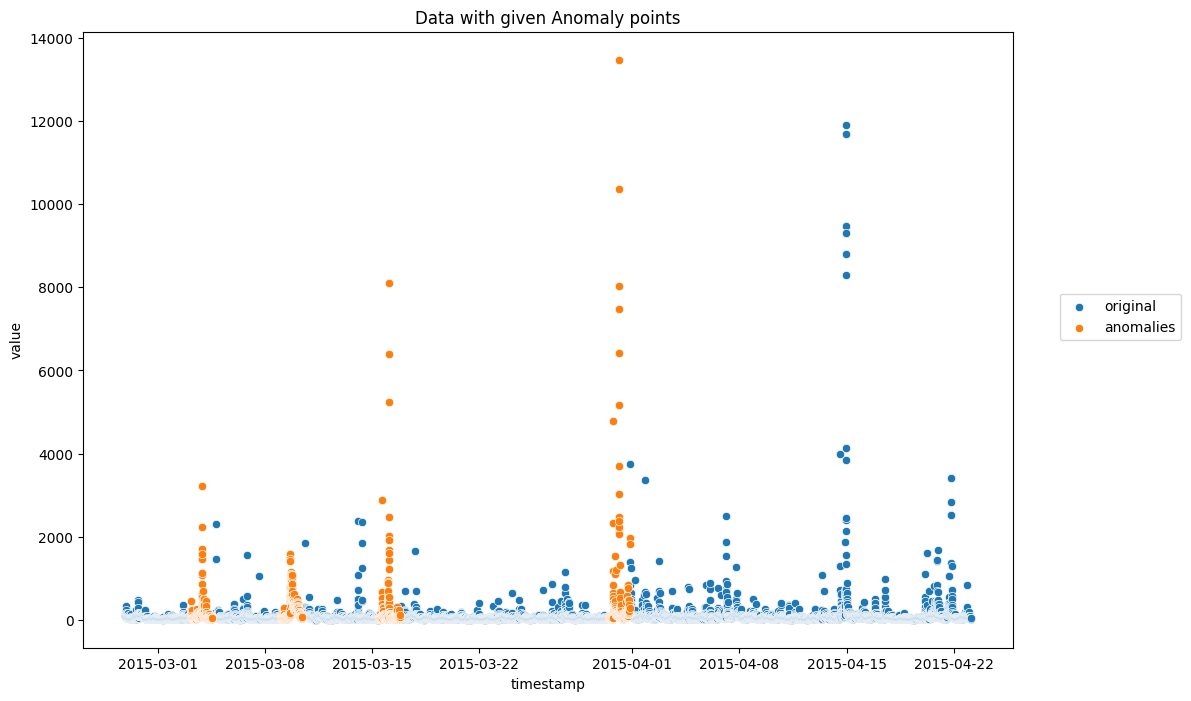

In [ ]:
plt.figure(figsize=(12,8), dpi=100)
sns.scatterplot(data=data['value'], label='original')
sns.scatterplot(data=anomalous_df['value'], label='anomalies')
plt.title('Data with given Anomaly points')
plt.legend(loc=(1.05, 0.5))
plt.show()

<Figure size 1200x800 with 0 Axes>

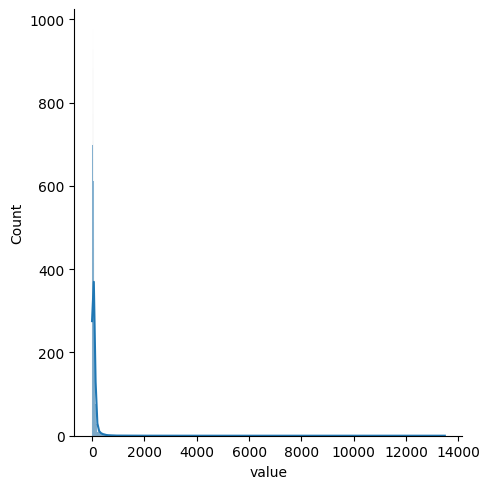

In [ ]:
plt.figure(figsize=(12,8), dpi=100)
sns.displot(data=data['value'], kde=True)
plt.show()

Data is scaled to balance impact of all variables

In [ ]:
scaler = MinMaxScaler()
data['value'] = scaler.fit_transform(data['value'].values.reshape(-1,1))
non_anomalous_df['value'] = scaler.fit_transform(non_anomalous_df['value'].values.reshape(-1,1))

In [ ]:
non_anomalous_df.head()

,value,anomaly
timestamp,,
2015-02-26 21:42:53,0.008740,0
2015-02-26 21:47:53,0.008404,0
2015-02-26 21:52:53,0.008320,0
2015-02-26 21:57:53,0.012942,0
2015-02-26 22:02:53,0.010085,0


In [ ]:
X = non_anomalous_df['value'].values
y = non_anomalous_df['anomaly'].values

Splitting of data into train and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(10019,)

In [ ]:
X_test.shape

(4295,)

Defining Generator, Discriminator and GAN model

In [ ]:
def build_generator(latent_dim):
  model = tf.keras.Sequential()
  model.add(Dense(64, input_dim=latent_dim))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

def build_discriminator(input_shape):
  model = tf.keras.Sequential()
  model.add(Dense(128, input_shape=(input_shape,)))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

def build_gan(generator, discriminator):
  discriminator.trainable= False
  gan_ip = Input(shape=(latent_dim,))
  x = generator(gan_ip)
  gan_op = discriminator(x)
  gan = Model(gan_ip, gan_op)
  gan.compile(loss='binary_crossentropy', optimizer='adam')
  return gan

Hyperparameters used

In [ ]:
latent_dim = 1 # input data stream dimension
sequence_length = 1 # length of time series sequences in dataset
epochs = 10 # number of times model goes through entire data
batch_size = 32

Compiling models

In [ ]:
discriminator = build_discriminator(sequence_length)
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
generator = build_generator(latent_dim)

GAN = build_gan(generator, discriminator)

Training the model

In [ ]:
for epoch in range(epochs):
  for _ in range(X_train.shape[0] // batch_size):
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    gen_data = generator.predict(noise)
    real_data = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(gen_data, fake_labels)

    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    g_loss = GAN.train_on_batch(noise, real_labels)

  if epoch % 1 == 0:
    print(f"Epoch {epoch}/{epochs}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")

X_all = data['value']
all_data_predictions = discriminator.predict(X_all)

1/1 [==============================] - 0s 23ms/step
Epoch 0/10, D Loss Real: 0.6891886591911316, D Loss Fake: 0.6923847794532776, G Loss: 0.6963409185409546
1/1 [==============================] - 0s 26ms/step
Epoch 1/10, D Loss Real: 0.6641695499420166, D Loss Fake: 0.6611899137496948, G Loss: 0.73748779296875
1/1 [==============================] - 0s 15ms/step
Epoch 2/10, D Loss Real: 0.6404368281364441, D Loss Fake: 0.6982595324516296, G Loss: 0.690909206867218
1/1 [==============================] - 0s 19ms/step
Epoch 3/10, D Loss Real: 0.0025313314981758595, D Loss Fake: 15.249238014221191, G Loss: 0.0
1/1 [==============================] - 0s 17ms/step
Epoch 4/10, D Loss Real: 0.0004377554287202656, D Loss Fake: 15.249238014221191, G Loss: 0.0
1/1 [==============================] - 0s 16ms/step
Epoch 5/10, D Loss Real: 0.0002392200694885105, D Loss Fake: 15.249238014221191, G Loss: 0.0
1/1 [==============================] - 0s 17ms/step
Epoch 6/10, D Loss Real: 0.000110672190203331

Calculate ROC curve to determine optimal threshold to determine anomlay points

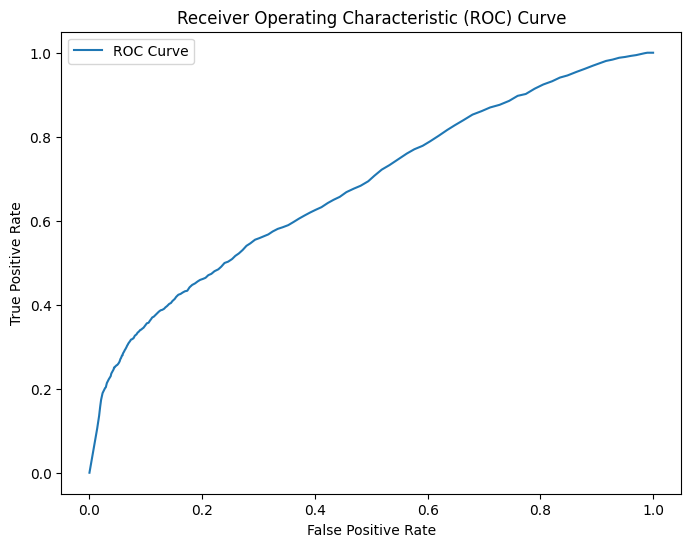


Optimal Threshold:  0.99998844
AUC-ROC Score: 0.68


In [ ]:
true_labels = data['anomaly'].values

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_data_predictions)
auc_roc = roc_auc_score(true_labels, all_data_predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Find the optimal threshold based on ROC curve
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]
print("\nOptimal Threshold: ", optimal_threshold)
print(f"AUC-ROC Score: {auc_roc:.2f}")
classified_data = (all_data_predictions > optimal_threshold).astype(int)

Visualize the true labels and predicted labels


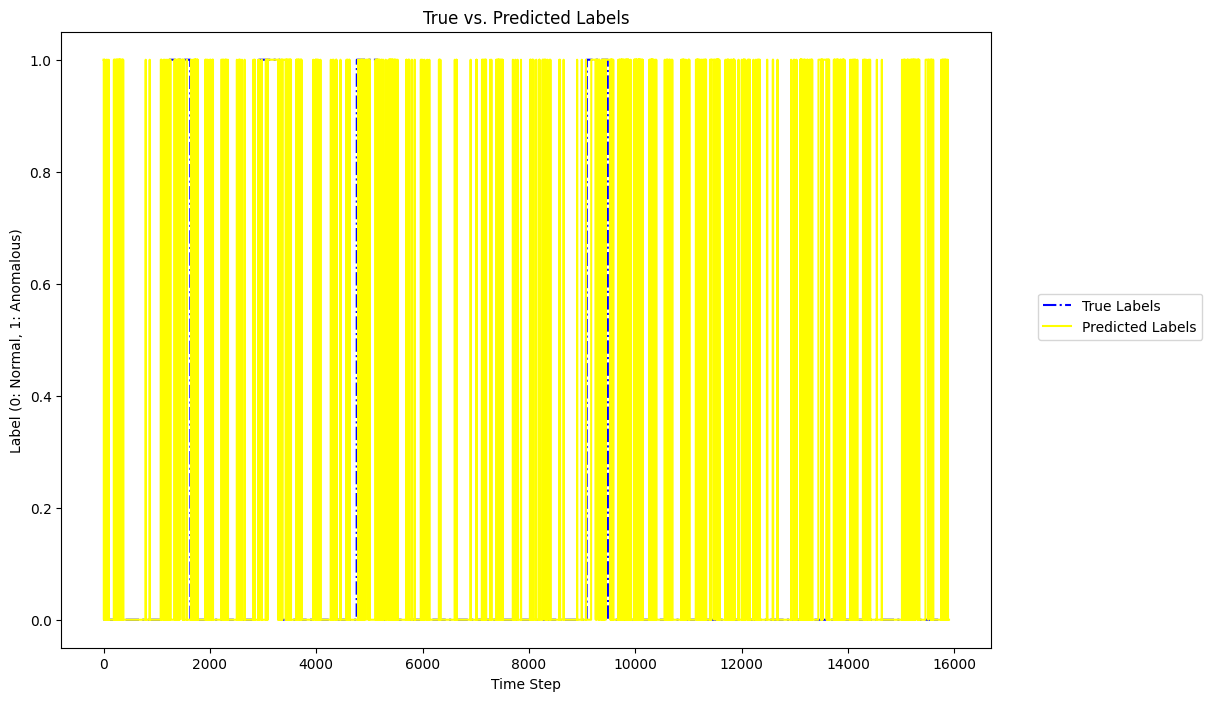

In [ ]:
plt.figure(figsize=(12, 8), dpi=100)

plt.plot(true_labels, label='True Labels', color='blue', linestyle='-.')
plt.plot(classified_data, label='Predicted Labels', color='yellow')

plt.xlabel('Time Step')
plt.ylabel('Label (0: Normal, 1: Anomalous)')
plt.title('True vs. Predicted Labels')
plt.legend(loc=(1.05,0.5))
plt.show()

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, classified_data, average='binary')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Precision: 0.23
Recall: 0.42
F1 Score: 0.30


Confusion Matrix:


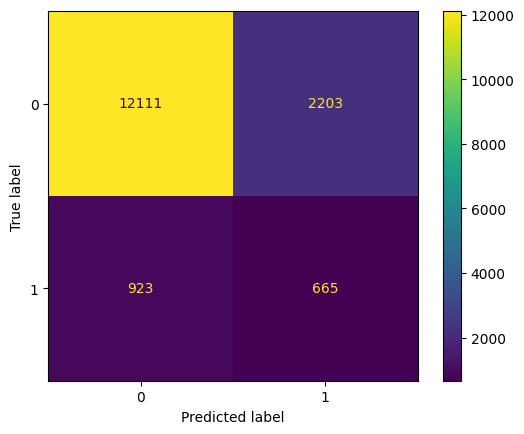

In [ ]:
print("Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix(true_labels, classified_data)).plot()

Mean squared error caclulation

In [ ]:
mse = np.mean(np.power(X_all.values - all_data_predictions, 2), axis=1)
error_df = pd.DataFrame({'error':mse, 'class':true_labels})

In [ ]:
error_df['error'].mean()

0.9878575405427885

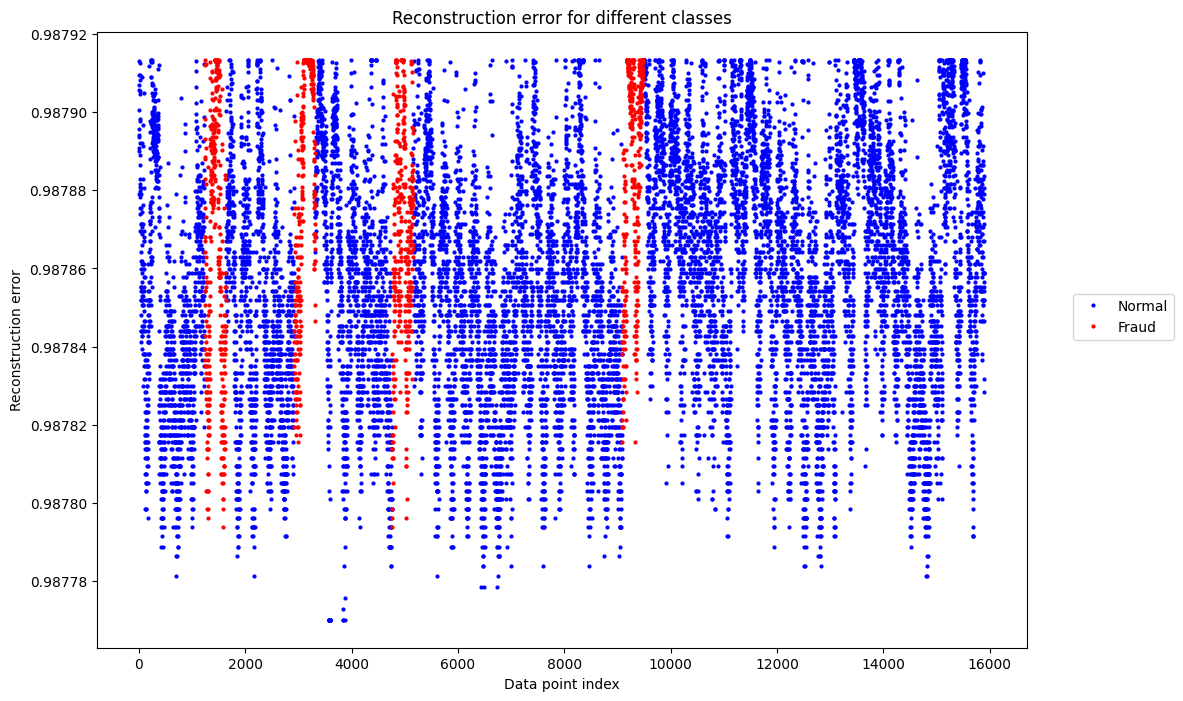

In [ ]:
groups = error_df.groupby('class')
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in groups:
    ax.plot(group.index, group.error, marker='o', ms=2.0, linestyle='',
            label = "Fraud" if name == 1 else "Normal",
            color = "red" if name == 1 else "blue")
# ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="green", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.legend(loc=(1.05, 0.5))
plt.show();

## Conclusion

1. Precision of 0.23 suggests that only 23% of the positive predictions were True Positives, suggesting that the model has a relatively high rate of False Positives
2. Recall of 0.42 means that the model captured 42% of actual positive cases
3. Based on evaluation metrics, the model seems to be struggling with correctly identifying positive instances and has relatively high rate of FP